In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

# --- Load the pickle file ---
files = ["jets_Q2_1.pkl", "jets_Q2_10.pkl", "jets_Q2_100.pkl"]

closest_pairs_list = []
unpaired_reco_list = []
unpaired_truth_list = []

for f in files:
    data = pd.read_pickle(f)
    closest_pairs_list.append(data["closest_pairs"])
    unpaired_reco_list.append(data["unpaired_reco"])
    unpaired_truth_list.append(data["unpaired_truth"])

closest_pairs = pd.concat(closest_pairs_list, ignore_index=True)
unpaired_reco = pd.concat(unpaired_reco_list, ignore_index=True)
unpaired_truth = pd.concat(unpaired_truth_list, ignore_index=True)

In [4]:
print("Reco")
print(len(unpaired_reco["eta"])+ len(closest_pairs["eta_reco"]))
print("Truth")
print(len(unpaired_truth["eta"]) + len(closest_pairs["eta_reco"]))
print("Pairs")
print(len(closest_pairs["eta_reco"]))
print("Efficiency")
print(100 * len(closest_pairs["eta_reco"]) / (len(unpaired_reco["eta"])+ len(closest_pairs["eta_reco"])))

# --- Combine reco jets (paired + unpaired) ---
# Paired reco jets come from closest_pairs
paired_reco = closest_pairs[["event", "reco_idx", "energy_reco", "eta_reco"]].copy()
paired_reco["paired"] = 1

# Unpaired reco jets are already given
unpaired_reco_df = unpaired_reco[["event", "reco_idx", "energy", "eta"]].copy()
unpaired_reco_df.rename(columns={"energy": "energy_reco", "eta": "eta_reco"}, inplace=True)
unpaired_reco_df["paired"] = 0

# Merge into a single dataframe
all_reco = pd.concat([paired_reco, unpaired_reco_df], ignore_index=True)

# Paired jets only
paired = closest_pairs.copy()

# Compute ratio
paired["energy_ratio"] = paired["energy_reco"] / paired["energy_truth"]

Reco
280376
Truth
307550
Pairs
163019
Efficiency
58.142993694182096


In [5]:
fit_results_response = []
fit_results_scale = []

# --- Configuration ---
e_bins = np.arange(0, 250, 5)
eta_min, eta_max = 3.0, 4.0
n_eta_bins = 4  # adjustable
eta_bins = np.linspace(eta_min, eta_max, n_eta_bins + 1)

min_points_for_fit = 20
n_hist_bins = 30
chi2_lim = 10

# --- Functions ---
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def reduced_chi2(y_obs, y_fit, y_err=None, n_params=3):
    if y_err is None:
        y_err = np.sqrt(np.maximum(y_obs, 1))
    chi2 = np.sum(((y_obs - y_fit) / y_err) ** 2)
    dof = len(y_obs) - n_params
    return np.inf if dof <= 0 else chi2 / dof

# --- Main Loop ---
for j in range(len(eta_bins) - 1):
    eta_low = eta_bins[j]
    eta_high = eta_bins[j + 1]
    eta_center = 0.5 * (eta_low + eta_high)

    for i in range(len(e_bins) - 1):
        e_low = e_bins[i]
        e_high = e_bins[i + 1]
        center_energy = 0.5 * (e_low + e_high)

        mask = (
            (paired["energy_truth"] >= e_low) &
            (paired["energy_truth"] < e_high) &
            (paired["eta_reco"] >= eta_low) &
            (paired["eta_reco"] < eta_high)
        )

        reco_in_bin = paired.loc[mask, "energy_reco"].values
        ratio_in_bin = paired.loc[mask, "energy_ratio"].values
        if len(reco_in_bin) < min_points_for_fit:
            continue

        # ===============================
        # Energy response fit
        # ===============================
        mu0 = np.mean(reco_in_bin)
        sigma0 = np.std(reco_in_bin)
        within_1sigma = (reco_in_bin >= mu0 - sigma0) & (reco_in_bin <= mu0 + sigma0)
        reco_fit_region = reco_in_bin[within_1sigma]
        if len(reco_fit_region) < min_points_for_fit:
            continue

        counts, edges = np.histogram(reco_in_bin, bins=n_hist_bins)
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
        bin_widths = np.diff(edges)
        total_entries = counts.sum()
        density = counts / (total_entries * bin_widths)
        errors = np.sqrt(counts) / (total_entries * bin_widths)
        errors[errors == 0] = np.min(errors[errors > 0])

        fit_mask = (bin_centers >= mu0 - sigma0) & (bin_centers <= mu0 + sigma0)
        x_fit, y_fit, y_err = bin_centers[fit_mask], density[fit_mask], errors[fit_mask]
        if len(x_fit) < 3:
            continue

        p0 = [y_fit.max(), mu0, sigma0]
        try:
            popt, pcov = curve_fit(gauss, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)
        except (RuntimeError, ValueError):
            continue

        mu_fit, sigma_fit = popt[1], popt[2]
        mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:3] if pcov.size else (np.nan, np.nan)
        chi2_ndf = reduced_chi2(y_fit, gauss(x_fit, *popt), y_err)

        if chi2_ndf <= chi2_lim and (mu0 - sigma0 <= mu_fit <= mu0 + sigma0):
            fit_results_response.append({
                "center_energy": center_energy,
                "energy_range": (e_low, e_high),
                "eta_center": eta_center,
                "eta_range": (eta_low, eta_high),
                "mu": mu_fit,
                "mu_err": mu_err,
                "sigma": sigma_fit,
                "sigma_err": sigma_err,
                "chi2_ndf": chi2_ndf
            })

        # ===============================
        # Energy scale fit
        # ===============================
        mu0_r = np.mean(ratio_in_bin)
        sigma0_r = np.std(ratio_in_bin)
        within_1sigma_r = (ratio_in_bin >= mu0_r - sigma0_r) & (ratio_in_bin <= mu0_r + sigma0_r)
        ratio_fit_region = ratio_in_bin[within_1sigma_r]
        if len(ratio_fit_region) < min_points_for_fit:
            continue

        counts_r, edges_r = np.histogram(ratio_in_bin, bins=n_hist_bins)
        bin_centers_r = 0.5 * (edges_r[:-1] + edges_r[1:])
        bin_widths_r = np.diff(edges_r)
        total_entries_r = counts_r.sum()
        density_r = counts_r / (total_entries_r * bin_widths_r)
        errors_r = np.sqrt(counts_r) / (total_entries_r * bin_widths_r)
        errors_r[errors_r == 0] = np.min(errors_r[errors_r > 0])

        fit_mask_r = (bin_centers_r >= mu0_r - sigma0_r) & (bin_centers_r <= mu0_r + sigma0_r)
        x_fit_r, y_fit_r, y_err_r = bin_centers_r[fit_mask_r], density_r[fit_mask_r], errors_r[fit_mask_r]
        if len(x_fit_r) < 3:
            continue

        p0_r = [y_fit_r.max(), mu0_r, sigma0_r]
        try:
            popt_r, pcov_r = curve_fit(gauss, x_fit_r, y_fit_r, p0=p0_r, sigma=y_err_r, absolute_sigma=True)
        except (RuntimeError, ValueError):
            continue

        mu_fit_r, sigma_fit_r = popt_r[1], popt_r[2]
        mu_err_r, sigma_err_r = np.sqrt(np.diag(pcov_r))[1:3] if pcov_r.size else (np.nan, np.nan)
        chi2_ndf_r = reduced_chi2(y_fit_r, gauss(x_fit_r, *popt_r), y_err_r)

        if chi2_ndf_r <= chi2_lim and (mu0_r - sigma0_r <= mu_fit_r <= mu0_r + sigma0_r):
            fit_results_scale.append({
                "center_energy": center_energy,
                "energy_range": (e_low, e_high),
                "eta_center": eta_center,
                "eta_range": (eta_low, eta_high),
                "mu": mu_fit_r,
                "mu_err": mu_err_r,
                "sigma": sigma_fit_r,
                "sigma_err": sigma_err_r,
                "chi2_ndf": chi2_ndf_r
            })

# --- Convert to DataFrames ---
df_fit_response = pd.DataFrame(fit_results_response)
df_fit_scale = pd.DataFrame(fit_results_scale)


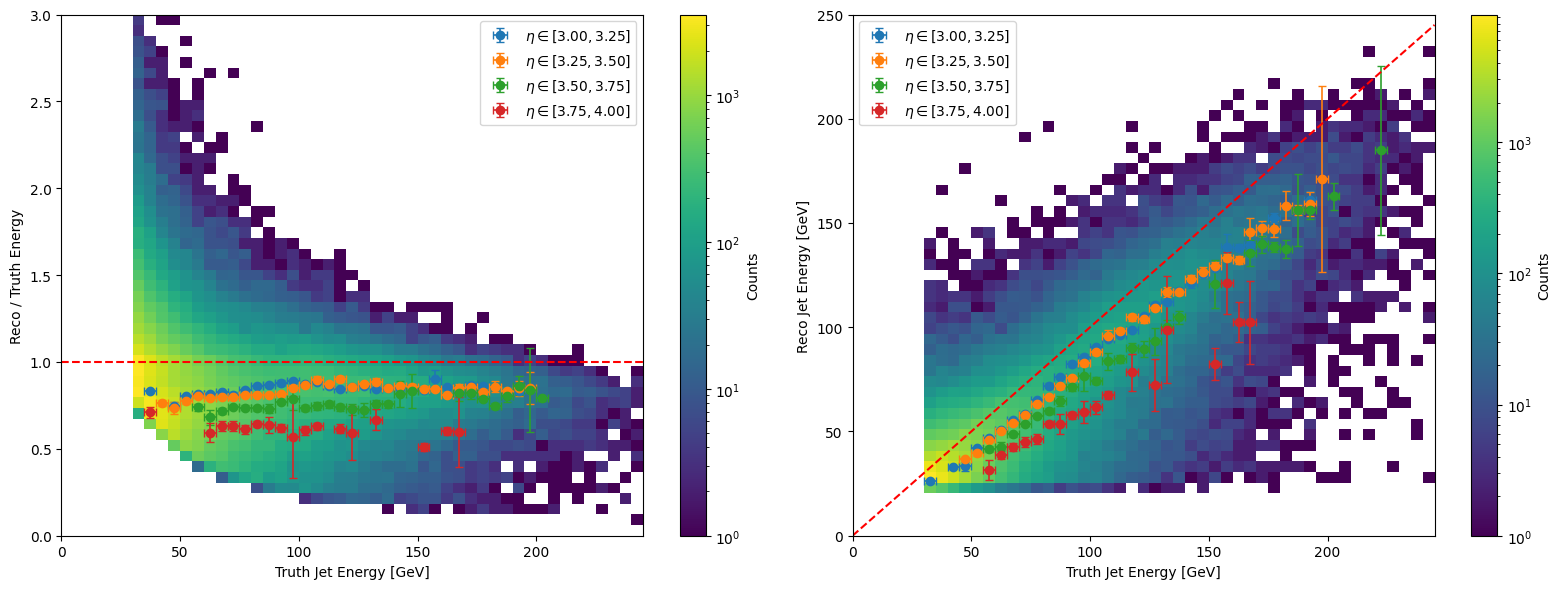

In [25]:
# --- 2D histogram parameters ---
x_bins = np.arange(0, 250, 5)
y_bins_ratio = np.linspace(0, 3, 50)
y_bins_reco = np.linspace(0, 250, 50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# ----------------------
# (1) Energy scale (ratio)
# ----------------------
ax = axes[0]
hist_ratio = ax.hist2d(
    paired["energy_truth"],
    paired["energy_ratio"],
    bins=[x_bins, y_bins_ratio],
    cmap="viridis",
    norm=mcolors.LogNorm()
)
fig.colorbar(hist_ratio[3], ax=ax, label="Counts")
ax.set_xlabel("Truth Jet Energy [GeV]")
ax.set_ylabel("Reco / Truth Energy")

# overlay fit results from all eta ranges
for eta_range, df_eta in df_fit_scale.groupby(df_fit_scale["eta_range"].apply(tuple)):
    e_range_width = 0.5 * (df_eta["energy_range"].apply(lambda x: x[1]-x[0]))
    ax.errorbar(
        df_eta["center_energy"],
        df_eta["mu"],
        yerr=df_eta["mu_err"],
        xerr=e_range_width,
        fmt='o',
        elinewidth=1.2,
        capsize=3,
        label=f"$\\eta\\in[{eta_range[0]:.2f},{eta_range[1]:.2f}]$"
    )
ax.legend(fontsize=10)
ax.axhline(1.0, color='red', linestyle='--', lw=1.5)
ax.legend(fontsize=10)

# ----------------------
# (2) Energy response (reco)
# ----------------------
ax = axes[1]
hist_reco = ax.hist2d(
    paired["energy_truth"],
    paired["energy_reco"],
    bins=[x_bins, y_bins_reco],
    cmap="viridis",
    norm=mcolors.LogNorm()
)
fig.colorbar(hist_reco[3], ax=ax, label="Counts")
ax.set_xlabel("Truth Jet Energy [GeV]")
ax.set_ylabel("Reco Jet Energy [GeV]")

for eta_range, df_eta in df_fit_response.groupby(df_fit_response["eta_range"].apply(tuple)):
    e_range_width = 0.5 * (df_eta["energy_range"].apply(lambda x: x[1]-x[0]))
    ax.errorbar(
        df_eta["center_energy"],
        df_eta["mu"],
        yerr=df_eta["mu_err"],
        xerr=e_range_width,
        fmt='o',
        elinewidth=1.2,
        capsize=3,
        label=f"$\\eta\\in[{eta_range[0]:.2f},{eta_range[1]:.2f}]$"
    )
ax.legend(fontsize=10)
x_line = np.array([0, x_bins.max()])
ax.plot(x_line, x_line, color='red', linestyle='--', lw=1.5)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


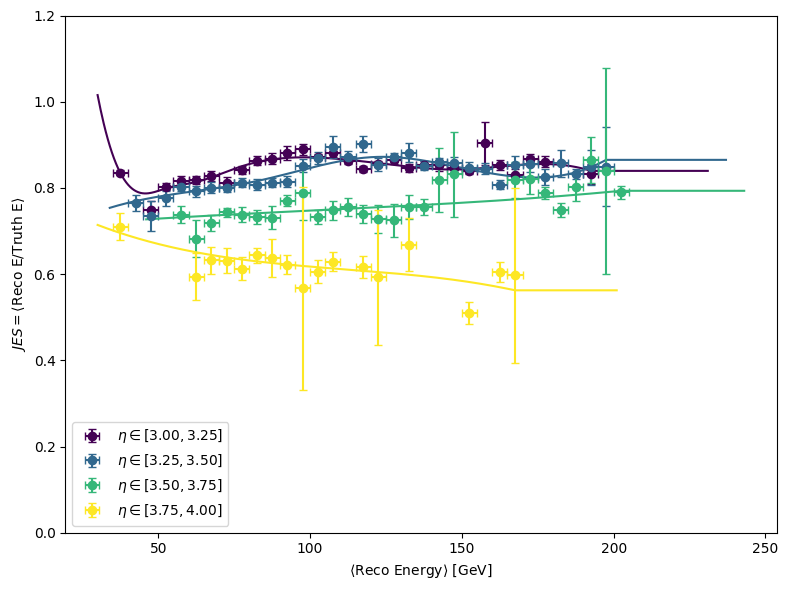

In [7]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt

# --- Assume df_fit_response and df_fit_scale contain "eta_range" column (tuple: (eta_min, eta_max)) ---

# Build a dictionary of splines per eta range
eta_splines = {}

for eta_range, df_eta in df_fit_scale.groupby(df_fit_scale["eta_range"].apply(tuple)):
    x_vals = df_eta["center_energy"].values
    y_vals = df_eta["mu"].values
    x_err = df_eta["mu_err"].values  # optional, can also use sigma if desired
    y_err = df_eta["mu_err"].values

    # Sort for spline
    sort_idx = np.argsort(x_vals)
    x_sorted = x_vals[sort_idx]
    y_sorted = y_vals[sort_idx]
    y_err_sorted = y_err[sort_idx]

    # Weights for spline
    weights = 1 / np.maximum(y_err_sorted, 1e-6)

    # Fit cubic spline
    spline = UnivariateSpline(x_sorted, y_sorted, w=weights, k=3, s=30)

    # Store spline and max energy for saturation
    eta_splines[eta_range] = {
        "spline": spline,
        "x_max": x_sorted.max(),
        "y_max": spline(x_sorted.max())
    }

# --- JES function ---
def JES(reco_energy, eta):
    reco_energy = np.asarray(reco_energy)
    out = np.empty_like(reco_energy, dtype=float)

    # find corresponding eta bin
    found = False
    for eta_range, info in eta_splines.items():
        eta_min, eta_max = eta_range
        mask = (eta >= eta_min) & (eta < eta_max)
        if np.any(mask):
            found = True
            spline = info["spline"]
            x_max = info["x_max"]
            y_max = info["y_max"]

            mask_low = mask & (reco_energy <= x_max)
            mask_high = mask & (reco_energy > x_max)

            out[mask_low] = spline(reco_energy[mask_low])
            out[mask_high] = y_max

    if not found:
        # fallback if eta outside defined ranges
        out[:] = 1.0

    return out

# --- Plot each eta range ---
plt.figure(figsize=(8,6))
colors = plt.cm.viridis(np.linspace(0,1,len(eta_splines)))

for (eta_range, info), c in zip(eta_splines.items(), colors):
    df_eta = df_fit_scale[df_fit_scale["eta_range"].apply(tuple) == eta_range]
    x_vals = df_eta["center_energy"].values
    y_vals = df_eta["mu"].values
    x_err = 0.5*(df_eta["energy_range"].apply(lambda r: r[1]-r[0]))
    y_err = df_eta["mu_err"].values

    plt.errorbar(
        x_vals, y_vals,
        xerr=x_err, yerr=y_err,
        fmt='o', color=c, ecolor=c, capsize=3,
        label=f"$\\eta \\in [{eta_range[0]:.2f},{eta_range[1]:.2f}]$"
    )

    # fine spline line
    x_fine = np.linspace(x_vals.min()*0.8, x_vals.max()*1.2, 600)
    spline = info["spline"]
    y_max = info["y_max"]
    y_fine = np.where(x_fine <= info["x_max"], spline(x_fine), y_max)
    plt.plot(x_fine, y_fine, '-', color=c)

plt.xlabel(r"$\langle \mathrm{Reco\ Energy} \rangle$ [GeV]")
plt.ylabel(r"$JES = \langle \mathrm{Reco\ E} / \mathrm{Truth\ E} \rangle$")
plt.ylim(0, 1.2)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Extract reco energies and eta
reco_energies = paired["energy_reco"].values
eta_vals = paired["eta_reco"].values

# Apply eta-dependent JES
corrected_energies = reco_energies / JES(reco_energies, eta_vals)

# Store in dataframe
paired["energy_reco_corrected"] = corrected_energies

paired["energy_ratio_corrected"] = paired["energy_reco_corrected"] / paired["energy_truth"]


In [13]:
fit_results_response_corr = []
fit_results_scale_corr = []

# --- Configuration ---
e_bins = np.arange(0, 250, 5)
eta_min, eta_max = 3.0, 4.0
n_eta_bins = 4  # adjustable
eta_bins = np.linspace(eta_min, eta_max, n_eta_bins + 1)

min_points_for_fit = 20
n_hist_bins = 30
chi2_lim = 10

# --- Main Loop ---
for j in range(len(eta_bins) - 1):
    eta_low = eta_bins[j]
    eta_high = eta_bins[j + 1]
    eta_center = 0.5 * (eta_low + eta_high)

    for i in range(len(e_bins) - 1):
        e_low = e_bins[i]
        e_high = e_bins[i + 1]
        center_energy = 0.5 * (e_low + e_high)

        mask = (
            (paired["energy_truth"] >= e_low) &
            (paired["energy_truth"] < e_high) &
            (paired["eta_reco"] >= eta_low) &
            (paired["eta_reco"] < eta_high)
        )

        reco_in_bin = paired.loc[mask, "energy_reco_corrected"].values
        ratio_in_bin = paired.loc[mask, "energy_ratio_corrected"].values
        if len(reco_in_bin) < min_points_for_fit:
            continue

        # ===============================
        # Energy response fit
        # ===============================
        mu0 = np.mean(reco_in_bin)
        sigma0 = np.std(reco_in_bin)
        within_1sigma = (reco_in_bin >= mu0 - sigma0) & (reco_in_bin <= mu0 + sigma0)
        reco_fit_region = reco_in_bin[within_1sigma]
        if len(reco_fit_region) < min_points_for_fit:
            continue

        counts, edges = np.histogram(reco_in_bin, bins=n_hist_bins)
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
        bin_widths = np.diff(edges)
        total_entries = counts.sum()
        density = counts / (total_entries * bin_widths)
        errors = np.sqrt(counts) / (total_entries * bin_widths)
        errors[errors == 0] = np.min(errors[errors > 0])

        fit_mask = (bin_centers >= mu0 - sigma0) & (bin_centers <= mu0 + sigma0)
        x_fit, y_fit, y_err = bin_centers[fit_mask], density[fit_mask], errors[fit_mask]
        if len(x_fit) < 3:
            continue

        p0 = [y_fit.max(), mu0, sigma0]
        try:
            popt, pcov = curve_fit(gauss, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)
        except (RuntimeError, ValueError):
            continue

        mu_fit, sigma_fit = popt[1], popt[2]
        mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:3] if pcov.size else (np.nan, np.nan)
        chi2_ndf = reduced_chi2(y_fit, gauss(x_fit, *popt), y_err)

        if chi2_ndf <= chi2_lim and (mu0 - sigma0 <= mu_fit <= mu0 + sigma0):
            fit_results_response_corr.append({
                "center_energy": center_energy,
                "energy_range": (e_low, e_high),
                "eta_center": eta_center,
                "eta_range": (eta_low, eta_high),
                "mu": mu_fit,
                "mu_err": mu_err,
                "sigma": sigma_fit,
                "sigma_err": sigma_err,
                "chi2_ndf": chi2_ndf
            })

        # ===============================
        # Energy scale fit
        # ===============================
        mu0_r = np.mean(ratio_in_bin)
        sigma0_r = np.std(ratio_in_bin)
        within_1sigma_r = (ratio_in_bin >= mu0_r - sigma0_r) & (ratio_in_bin <= mu0_r + sigma0_r)
        ratio_fit_region = ratio_in_bin[within_1sigma_r]
        if len(ratio_fit_region) < min_points_for_fit:
            continue

        counts_r, edges_r = np.histogram(ratio_in_bin, bins=n_hist_bins)
        bin_centers_r = 0.5 * (edges_r[:-1] + edges_r[1:])
        bin_widths_r = np.diff(edges_r)
        total_entries_r = counts_r.sum()
        density_r = counts_r / (total_entries_r * bin_widths_r)
        errors_r = np.sqrt(counts_r) / (total_entries_r * bin_widths_r)
        errors_r[errors_r == 0] = np.min(errors_r[errors_r > 0])

        fit_mask_r = (bin_centers_r >= mu0_r - sigma0_r) & (bin_centers_r <= mu0_r + sigma0_r)
        x_fit_r, y_fit_r, y_err_r = bin_centers_r[fit_mask_r], density_r[fit_mask_r], errors_r[fit_mask_r]
        if len(x_fit_r) < 3:
            continue

        p0_r = [y_fit_r.max(), mu0_r, sigma0_r]
        try:
            popt_r, pcov_r = curve_fit(gauss, x_fit_r, y_fit_r, p0=p0_r, sigma=y_err_r, absolute_sigma=True)
        except (RuntimeError, ValueError):
            continue

        mu_fit_r, sigma_fit_r = popt_r[1], popt_r[2]
        mu_err_r, sigma_err_r = np.sqrt(np.diag(pcov_r))[1:3] if pcov_r.size else (np.nan, np.nan)
        chi2_ndf_r = reduced_chi2(y_fit_r, gauss(x_fit_r, *popt_r), y_err_r)

        if chi2_ndf_r <= chi2_lim and (mu0_r - sigma0_r <= mu_fit_r <= mu0_r + sigma0_r):
            fit_results_scale_corr.append({
                "center_energy": center_energy,
                "energy_range": (e_low, e_high),
                "eta_center": eta_center,
                "eta_range": (eta_low, eta_high),
                "mu": mu_fit_r,
                "mu_err": mu_err_r,
                "sigma": sigma_fit_r,
                "sigma_err": sigma_err_r,
                "chi2_ndf": chi2_ndf_r
            })

# --- Convert to DataFrames ---
df_fit_response_corr = pd.DataFrame(fit_results_response_corr)
df_fit_scale_corr = pd.DataFrame(fit_results_scale_corr)


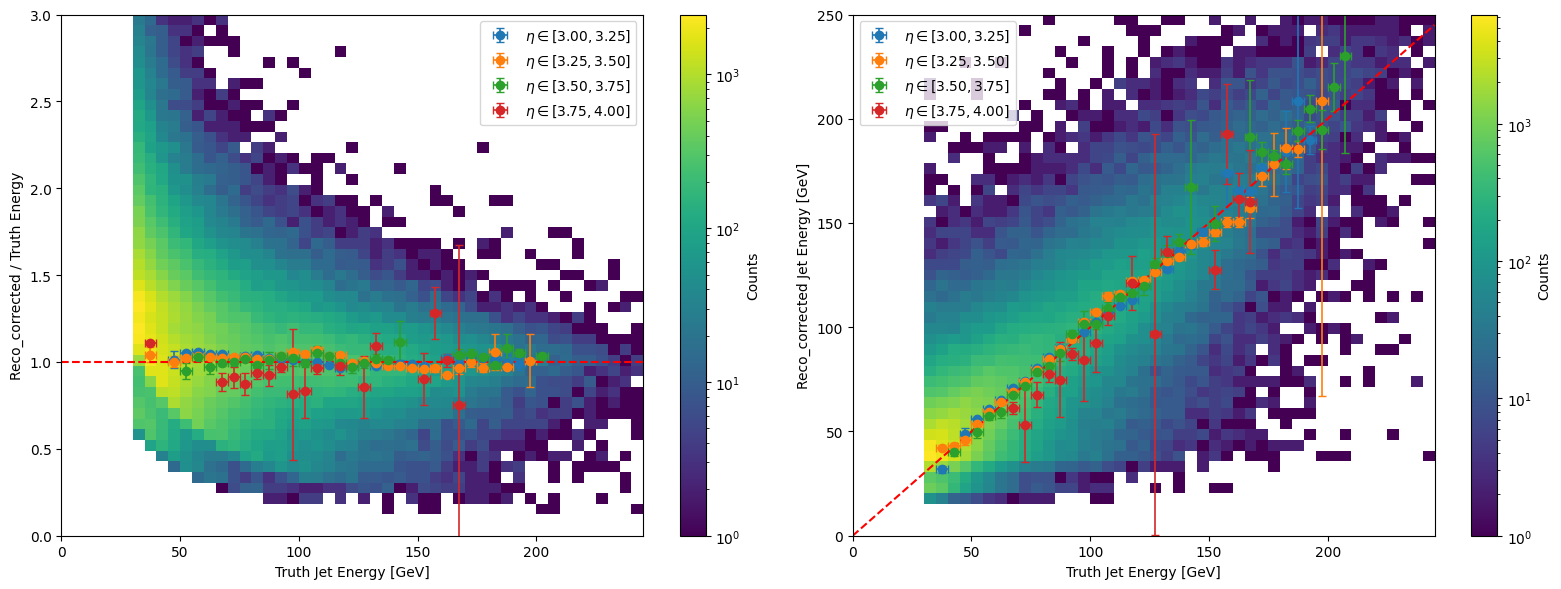

In [26]:
# --- 2D histogram parameters ---
x_bins = np.arange(0, 250, 5)
y_bins_ratio = np.linspace(0, 3, 50)
y_bins_reco = np.linspace(0, 250, 50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# ----------------------
# (1) Energy scale (ratio)
# ----------------------
ax = axes[0]
hist_ratio = ax.hist2d(
    paired["energy_truth"],
    paired["energy_ratio_corrected"],  # corrected ratio
    bins=[x_bins, y_bins_ratio],
    cmap="viridis",
    norm=mcolors.LogNorm()
)
fig.colorbar(hist_ratio[3], ax=ax, label="Counts")
ax.set_xlabel("Truth Jet Energy [GeV]")
ax.set_ylabel("Reco_corrected / Truth Energy")

# overlay corrected fit results from all eta ranges
for eta_range, df_eta in df_fit_scale_corr.groupby(df_fit_scale_corr["eta_range"].apply(tuple)):
    e_range_width = 0.5 * (df_eta["energy_range"].apply(lambda x: x[1]-x[0]))
    ax.errorbar(
        df_eta["center_energy"],
        df_eta["mu"],
        yerr=df_eta["mu_err"],
        xerr=e_range_width,
        fmt='o',
        elinewidth=1.2,
        capsize=3,
        label=f"$\\eta\\in[{eta_range[0]:.2f},{eta_range[1]:.2f}]$"
    )

# horizontal line at 1 for JES
ax.axhline(1.0, color='red', linestyle='--', lw=1.5)
ax.legend(fontsize=10)

# ----------------------
# (2) Energy response (reco)
# ----------------------
ax = axes[1]
hist_reco = ax.hist2d(
    paired["energy_truth"],
    paired["energy_reco_corrected"],  # corrected reco energy
    bins=[x_bins, y_bins_reco],
    cmap="viridis",
    norm=mcolors.LogNorm()
)
fig.colorbar(hist_reco[3], ax=ax, label="Counts")
ax.set_xlabel("Truth Jet Energy [GeV]")
ax.set_ylabel("Reco_corrected Jet Energy [GeV]")

for eta_range, df_eta in df_fit_response_corr.groupby(df_fit_response_corr["eta_range"].apply(tuple)):
    e_range_width = 0.5 * (df_eta["energy_range"].apply(lambda x: x[1]-x[0]))
    ax.errorbar(
        df_eta["center_energy"],
        df_eta["mu"],
        yerr=df_eta["mu_err"],
        xerr=e_range_width,
        fmt='o',
        elinewidth=1.2,
        capsize=3,
        label=f"$\\eta\\in[{eta_range[0]:.2f},{eta_range[1]:.2f}]$"
    )

# red line with slope 1
x_line = np.array([0, x_bins.max()])
ax.plot(x_line, x_line, color='red', linestyle='--', lw=1.5)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


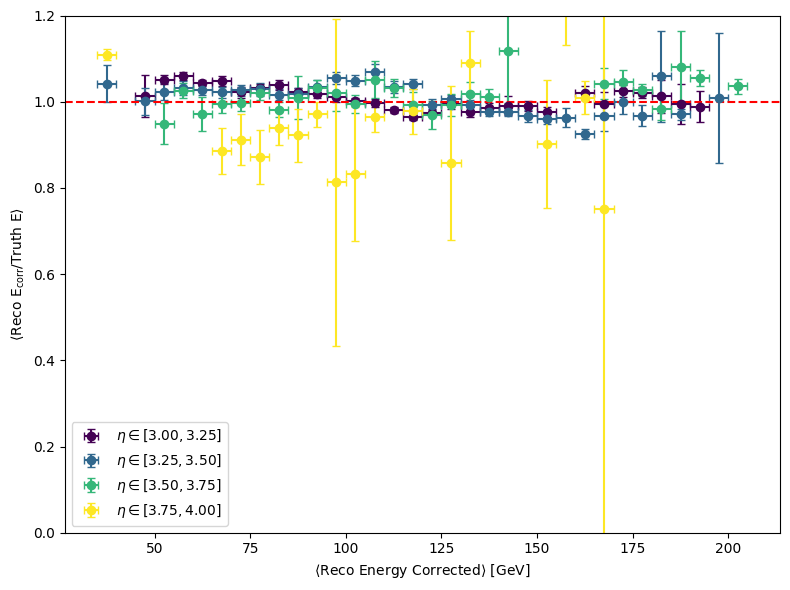

In [20]:
# --- Plot each eta range separately ---
plt.figure(figsize=(8,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(df_fit_scale_corr["eta_range"].unique())))

for (eta_range, c) in zip(df_fit_scale_corr["eta_range"].unique(), colors):
    df_eta = df_fit_scale_corr[df_fit_scale_corr["eta_range"] == eta_range]

    x_vals = df_eta["center_energy"].values
    y_vals = df_eta["mu"].values
    x_err = 0.5 * np.array([r[1]-r[0] for r in df_eta["energy_range"].values])
    y_err = df_eta["mu_err"].values

    plt.errorbar(
        x_vals, y_vals,
        xerr=x_err, yerr=y_err,
        fmt='o', color=c, ecolor=c, capsize=3,
        label=r"$\eta \in [{:.2f}, {:.2f}]$".format(eta_range[0], eta_range[1])
    )
plt.axhline(1.0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel(r"$\langle \mathrm{Reco\ Energy\ Corrected} \rangle$ [GeV]")
plt.ylabel(r"$\langle \mathrm{Reco\ E_{corr}} / \mathrm{Truth\ E} \rangle$")
plt.ylim(0, 1.2)
plt.legend()
plt.tight_layout()
plt.show()


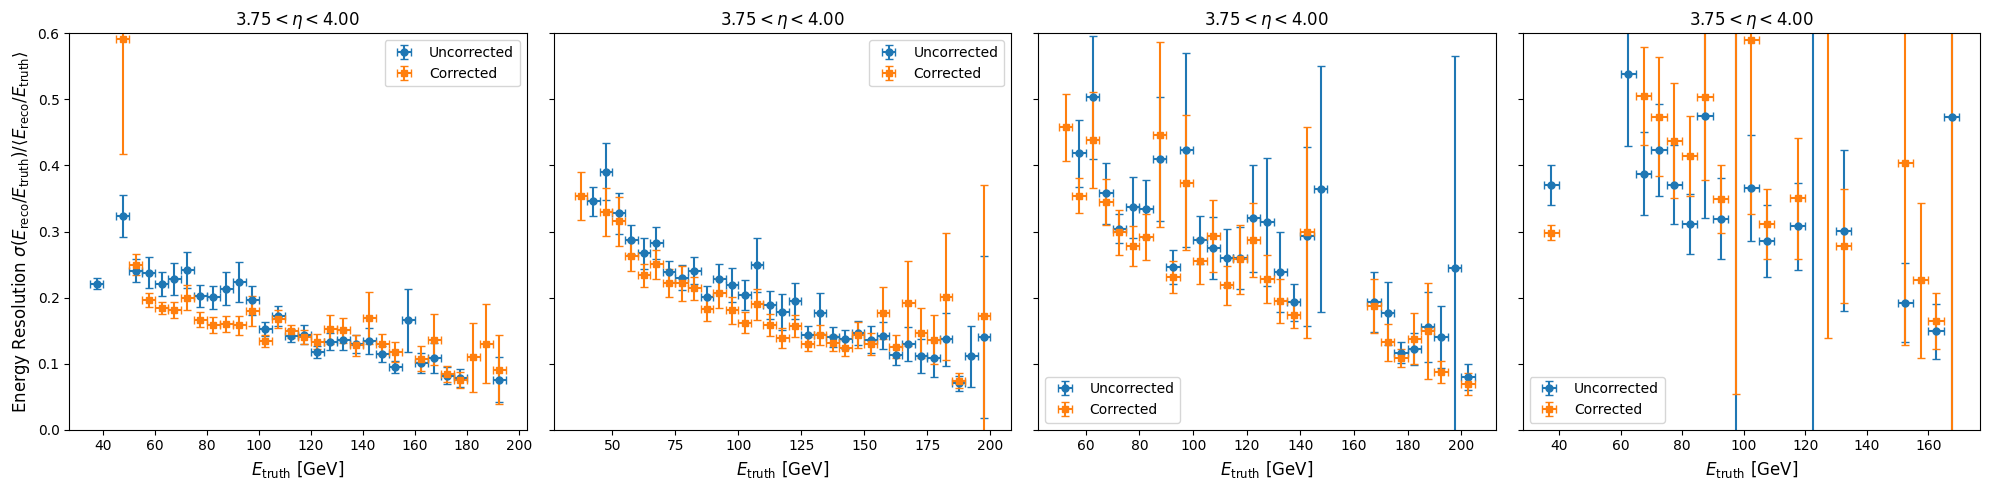

In [27]:
# --- Convert fit results to DataFrames if not already ---
df_uncorr = pd.DataFrame(fit_results_scale)
df_corr = pd.DataFrame(fit_results_scale_corr)

# --- Configuration ---
eta_bins = sorted(df_uncorr["eta_center"].unique())
n_eta = len(eta_bins)

def compute_resolution(df):
    x = np.array([(low + high) / 2 for low, high in df["energy_range"]])
    xerr = np.array([(high - low) / 2 for low, high in df["energy_range"]])
    mu = df["mu"].values
    sigma = df["sigma"].values
    mu_err = df["mu_err"].values
    sigma_err = df["sigma_err"].values
    resolution = sigma / mu
    resolution_err = resolution * np.sqrt((sigma_err / sigma)**2 + (mu_err / mu)**2)
    return x, xerr, resolution, resolution_err

# --- Plot setup ---
fig, axes = plt.subplots(1, n_eta, figsize=(5*n_eta, 5), sharey=True)

if n_eta == 1:
    axes = [axes]

for i, eta_center in enumerate(eta_bins):
    ax = axes[i]
    
    df_u = df_uncorr[df_uncorr["eta_center"] == eta_center]
    df_c = df_corr[df_corr["eta_center"] == eta_center]
    
    x_u, xerr_u, res_u, res_err_u = compute_resolution(df_u)
    x_c, xerr_c, res_c, res_err_c = compute_resolution(df_c)
    
    ax.errorbar(x_u, res_u, xerr=xerr_u, yerr=res_err_u,
                fmt='o', capsize=3, markersize=5, label='Uncorrected')
    ax.errorbar(x_c, res_c, xerr=xerr_c, yerr=res_err_c,
                fmt='s', capsize=3, markersize=5, label='Corrected')
    
    ax.set_xlabel(r"$E_{\mathrm{truth}}\ [\mathrm{GeV}]$", fontsize=12)
    ax.set_title(r"${:.2f} < \eta < {:.2f}$".format(eta_low, eta_high))

    ax.set_ylim(0,0.6)
    if i == 0:
        ax.set_ylabel(r"Energy Resolution $\sigma(E_{\mathrm{reco}}/E_{\mathrm{truth}})/\langle E_{\mathrm{reco}}/E_{\mathrm{truth}}\rangle$", fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()
